In [1]:
#default_exp suite

# Model Suite

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split

from evtdemand import data, feature

from tqdm import tqdm
from typing import Protocol
from importlib import import_module

In [3]:
from IPython.display import JSON

In [4]:
data_dir = '../data'
real_power_data_dir = '../data/real_power'

df_features, df_target = data.construct_baseline_features_target_dfs(data_dir)
# df_features = feature.create_additional_features(df_features, df_target)

In [31]:
#exports
class ScikitModel(Protocol):
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...
    def score(self, X, y, sample_weight=None): ...
    def set_params(self, **params): ...
    
def create_train_test_indexes(X, **split_kwargs):
    if 'n_splits' not in split_kwargs.keys():
        assert 'test_size' in split_kwargs.keys(), 'You must provide either `n_splits` or `test_size` within the `split_kwargs` parameters'
        size = X.shape[0]
        index_array = np.linspace(0, size-1, size).astype(int)
        train_test_indexes = [tuple(train_test_split(index_array, **split_kwargs))]
    else:
        kf = KFold(**split_kwargs)
        train_test_indexes = kf.split(X)
        
    return train_test_indexes
    
def calculate_error_metrics(y1, y2, y1_pred, y2_pred, y_baseline):
    baseline_combined_rmse = np.sqrt(np.square(y_baseline - y1).sum() + np.square(y_baseline - y2).sum())
    combined_rmse = np.sqrt(np.square(y1_pred - y1).sum() + np.square(y2_pred - y2).sum())
    
    error_metrics = {
        'y1_rmse': np.sqrt(np.square(y1_pred - y1).sum()),
        'y2_rmse': np.sqrt(np.square(y2_pred - y2).sum()),
        'combined_rmse': combined_rmse,
        'skill_score': combined_rmse/baseline_combined_rmse
    }

    return error_metrics

class ModelSuite:
    def __init__(
        self,
        model_1: ScikitModel=RandomForestRegressor(),
        model_2: ScikitModel=RandomForestRegressor(),
    ):
        self.set_models(model_1, model_2)
        
        return
    
    def set_models(
        self,
        model_1: ScikitModel=RandomForestRegressor(),
        model_2: ScikitModel=RandomForestRegressor(),
        trained: bool=False
    ):
        self.model_1 = model_1
        self.model_2 = model_2
        
        self.trained = trained
        
        return 
    
    def fit_models(
        self,
        X: np.ndarray,
        y1: np.ndarray,
        y2: np.ndarray,
    ):
        self.model_1.fit(X, y1)
        self.model_2.fit(X, y2)
        
        self.trained = True
        
        return 
    
    def predict_models(
        self,
        X: np.ndarray
    ):
        y1_pred = self.model_1.predict(X)
        y2_pred = self.model_2.predict(X)
        
        return y1_pred, y2_pred
    
    def construct_prediction_df(
        self,
        y1_pred: np.ndarray,
        y2_pred: np.ndarray,
        index: pd.Index
    ):
        df_pred = pd.DataFrame({'value_max': y1_pred, 'value_min': y2_pred}, index=index)
        df_pred.index.name = 'time'
        df_pred.index = index.tz_convert(None)
        
        return df_pred
    
    def run_test(
        self,
        df_target: pd.DataFrame,
        df_features: pd.DataFrame,
        y1_col: str='value_max',
        y2_col: str='value_min',
        split_kwargs: dict={
            'test_size': 0.1, 
            'shuffle': False
        }
    ):
        X = df_features.values
        y1, y2 = df_target[y1_col].values, df_target[y2_col].values
        y_baseline = df_features['value'].values
        
        error_metrics = []
        df_pred = pd.DataFrame()
        train_test_indexes = create_train_test_indexes(X, **split_kwargs)
        
        for train_index, test_index in train_test_indexes:
            X_train, X_test, y1_train, y1_test, y2_train, y2_test, y_baseline_train, y_baseline_test = X[train_index], X[test_index], y1[train_index], y1[test_index], y2[train_index], y2[test_index], y_baseline[train_index], y_baseline[test_index]
            self.fit_models(X_train, y1_train, y2_train)
            y1_pred, y2_pred = self.predict_models(X_test)
            
            df_pred = df_pred.append(self.construct_prediction_df(y1_pred, y2_pred, df_features.index[test_index]).assign(observed=y_baseline_test))
            error_metrics += [calculate_error_metrics(y1_test, y2_test, y1_pred, y2_pred, y_baseline_test)]
        
        df_pred = df_pred.sort_index()
        avg_error_metrics = pd.DataFrame(error_metrics).mean().to_dict()

        return avg_error_metrics, df_pred
    
    def run_submission(
        self,
        df_train_target: pd.DataFrame,
        df_train_features: pd.DataFrame,
        df_submission_features: pd.DataFrame,
        submissions_dir: str='../data/submission',
        y1_col: str='value_max',
        y2_col: str='value_min',
        save_submission: bool=False
    ):
        X_train = df_train_features.values
        y1_train, y2_train = df_train_target[y1_col].values, df_train_target[y2_col].values
        X_submission = df_submission_features.values
        submission_index = df_submission_features.index
        
        self.fit_models(X_train, y1_train, y2_train)
        y1_submission, y2_submission = self.predict_models(X_submission)
        
        df_pred = self.construct_prediction_df(y1_submission, y2_submission, submission_index)
        
        if save_submission == True:
            df_pred.to_csv(f'{submissions_dir}/predictions.csv')
            df_pred.to_csv(f'{submissions_dir}/archive/predictions_{pd.Timestamp.now().strftime("%Y-%m-%d %H-%M-%S")}.csv')

        return df_pred

In [20]:
# add example here of training, testing, and submission

In [35]:
#exports
def load_module_attr(module_attr_path: str):
    *module, attr = module_attr_path.split('.')
    assert len(module)>0, 'A module has not been passed, only an attribute'
    func = getattr(import_module('.'.join(module)), attr)

    return func
    
def run_parameterised_model(
    data_dir: str='data',
    model_1: str='sklearn.ensemble.RandomForestRegressor', # these can be any sklearn compatible model
    model_2: str='sklearn.ensemble.RandomForestRegressor',
    model_1_kwargs: dict={},
    model_2_kwargs: dict={},
    data_kwargs: dict={
        'real_power_sub_dir': 'real_power',
        'weather_sub_dir': 'weather',
        'real_power_time_period': '_pre_august',
        'real_power_site': 'Staplegrove_CB905',
        'weather_grid_point': 'staplegrove_1',
        'weather_interpolate_method': 'interpolate'
    },
    y1_col: str='value_max',
    y2_col: str='value_min',
    split_kwargs: dict={
        'test_size': 0.1, 
        'shuffle': False
    },
    cols_subset: list=['value', 'temperature', 'solar_irradiance', 'pressure',
                       'spec_humidity', 'hour', 'windspeed_north', 'windspeed_east', 
                       'doy', 'speed', 'direction', 'weekend', 'hcdh'],
    features_kwargs: dict={
        'features': ['temporal', 'dir_speed', 'hcdh']
    }
):
    input_data = locals()
    
    # data loading, generation, and processing
    df_features, df_target = data.construct_baseline_features_target_dfs(data_dir, **data_kwargs)
    df_features = feature.create_additional_features(df_features, df_target, **features_kwargs)
    df_features = feature.process_features(df_features, cols_subset=cols_subset)
    
    # model loading
    if isinstance(model_1, str):
        model_1 = load_module_attr(model_1)
    if isinstance(model_2, str):
        model_2 = load_module_attr(model_2)
    
    # model run
    model_suite = ModelSuite(model_1(**model_1_kwargs), model_2(**model_2_kwargs))
    error_metrics, df_pred = model_suite.run_test(df_target, df_features, y1_col=y1_col, y2_col=y2_col, split_kwargs=split_kwargs)
    
    return model_suite, error_metrics, df_pred, input_data

In [22]:
%%time

split_kwargs = {'n_splits': 2, 'shuffle': False}

model_suite, error_metrics, df_pred, input_data = run_parameterised_model(data_dir=data_dir, split_kwargs=split_kwargs)

error_metrics

Wall time: 1min 52s


{'y1_rmse': 17.506625161429554,
 'y2_rmse': 18.633093880505484,
 'combined_rmse': 25.57088621883296,
 'skill_score': 0.5303326037318531}

<AxesSubplot:xlabel='time'>

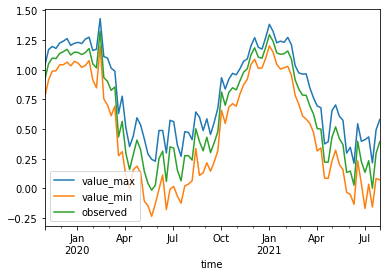

In [28]:
df_pred.resample('7D').mean().plot()

In [9]:
%%time

model_1.fit(X, y1)
model_2.fit(X, y2)

Wall time: 47.8 s


RandomForestRegressor()

In [10]:
df_observation_submission = data.load_real_power_dataset(f'{data_dir}/real_power', site='Staplegrove_CB905', real_power_variable='observation_variable_half_hourly', time_period='_august')
df_weather = data.load_weather_df(f'{data_dir}/weather', 'staplegrove_1')

common_idxs = df_observation_submission.index.intersection(df_weather.index)

df_features = df_observation_submission.loc[common_idxs].copy()
df_features[df_weather.columns] = df_weather.loc[common_idxs].copy()
# df_features = feature.create_additional_features(df_features)
# need to combine the historic and new feature data before creating the 

X_submission = df_features.values

X_submission.shape

(1488, 7)

In [21]:
y1_submission = model_1.predict(X_submission)
y2_submission = model_2.predict(X_submission)

df_submission = pd.DataFrame({'value_max': y1_submission, 'value_min': y2_submission}, index=df_features.index)
df_submission.index.name = 'time'
df_submission.index = df_submission.index.tz_convert(None)

df_submission.to_csv('../data/submission/predictions.csv')
df_submission.to_csv(f'../data/submission/archive/predictions_{pd.Timestamp.now().strftime("%Y-%m-%d %H-%M")}.csv')

In [36]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 01-data-processing.ipynb.
Converted 02-spatial-analysis.ipynb.
Converted 03a-feature-generation.ipynb.
Converted 03b-eda.ipynb.
Converted 04-model-suite.ipynb.
Converted 05-submission.ipynb.
Converted 06-experiments.ipynb.
